In [1]:
import math
import scipy
import timeit
import time
import threading
import csv
import cv2
import joblib
import shutil
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from glob import glob
from tqdm.notebook import tqdm as tqdm
from scipy import stats
from collections import Counter
from sklearn.utils import class_weight

import tensorflow as tf
import tensorflow_addons as tfa
import keras
from tensorflow.keras.utils import load_img, img_to_array
from keras.utils import to_categorical

from keras.applications.inception_resnet_v2 import preprocess_input
from keras.models import load_model, Sequential
from keras.applications import InceptionResNetV2
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import LeaveOneOut, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/oxml-carinoma-classification/img_701568.png
/kaggle/input/oxml-carinoma-classification/img_405863.png
/kaggle/input/oxml-carinoma-classification/img_217481.png
/kaggle/input/oxml-carinoma-classification/img_136044.png
/kaggle/input/oxml-carinoma-classification/img_585360.png
/kaggle/input/oxml-carinoma-classification/img_779156.png
/kaggle/input/oxml-carinoma-classification/img_38771.png
/kaggle/input/oxml-carinoma-classification/img_57613.png
/kaggle/input/oxml-carinoma-classification/img_279108.png
/kaggle/input/oxml-carinoma-classification/img_39157.png
/kaggle/input/oxml-carinoma-classification/img_769175.png
/kaggle/input/oxml-carinoma-classification/img_520490.png
/kaggle/input/oxml-carinoma-classification/img_630916.png
/kaggle/input/oxml-carinoma-classification/img_583497.png
/kaggle/input/oxml-carinoma-classification/img_531231.png
/kaggle/input/oxml-carinoma-classification/img_215078.png
/kaggle/input/oxml-carinoma-classification/img_49868.png
/kaggle/input/oxml

## EDA

In [3]:
pngs_list = glob('/kaggle/input/oxml-carinoma-classification/*png')
df = pd.read_csv('/kaggle/input/oxml-carinoma-classification/labels.csv')
df.head()

,id,malignant
0,441,-1
1,33284,-1
2,38771,1
3,46784,-1
4,57613,-1


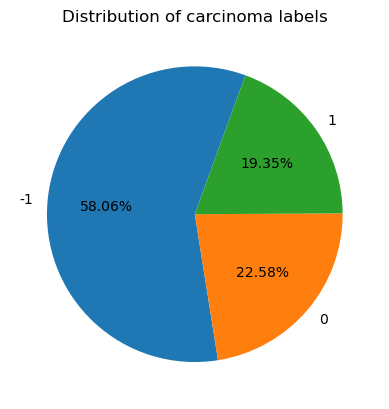


Carcinoma neg (-1): 36
Carcinoma pos, benign (0): 14
Carcinoma pos, malignant (1): 12



In [4]:
# Label Distribution
#Carcinoma neg (-1) Carcinoma pos, benign (0) Carcinoma pos, malignant (1)

value_counts = df['malignant'].value_counts()
fig, ax = plt.subplots()
ax.pie(value_counts, labels=value_counts.index, autopct='%.2f%%', startangle=70)
ax.set_title('Distribution of carcinoma labels')
plt.show()
print('''
Carcinoma neg (-1): {}
Carcinoma pos, benign (0): {}
Carcinoma pos, malignant (1): {}
'''.format(value_counts[-1], value_counts[0], value_counts[1]))

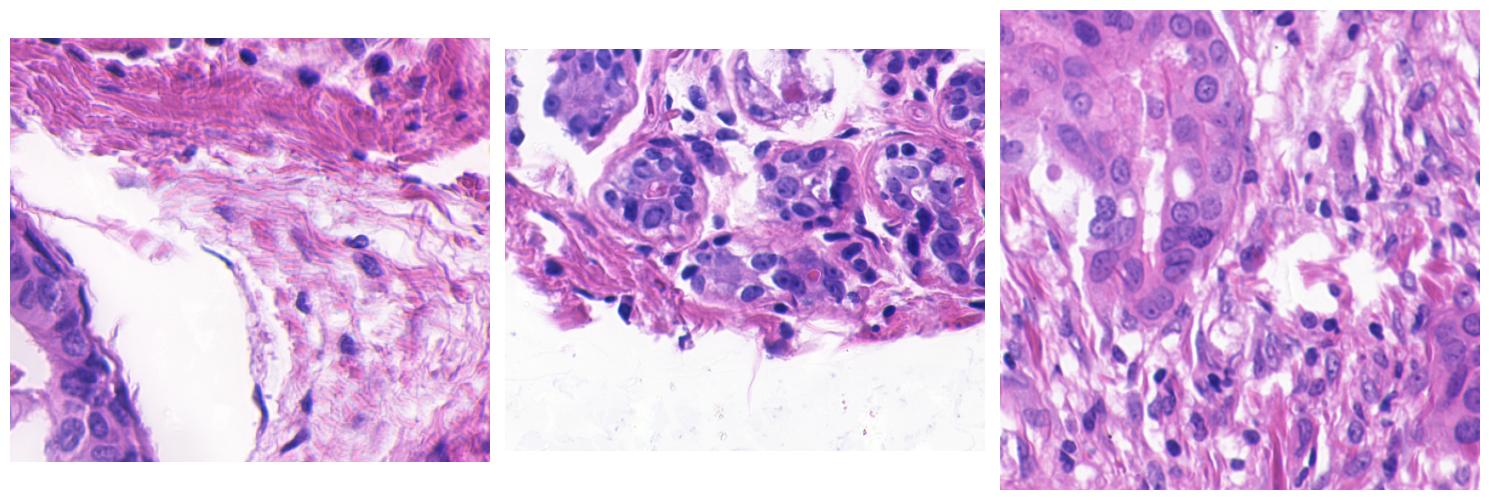

In [5]:
#image[0] -> -1, image[1] -> 0, image[2] -> 1
image_paths = [
    "/kaggle/input/oxml-carinoma-classification/img_441.png",
    "/kaggle/input/oxml-carinoma-classification/img_74682.png",
    "/kaggle/input/oxml-carinoma-classification/img_38771.png"
]

fig, axs = plt.subplots(1, 3, figsize=(15, 10))

for i, image_path in enumerate(image_paths):
    image = mpimg.imread(image_path)
    axs[i].imshow(image)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

Split files to Train-Test directories.

In [6]:
source_dir = "/kaggle/input/oxml-carinoma-classification/"

# Destination directories for train and test sets
train_dir = "/kaggle/working/train/"
val_dir = "/kaggle/working/validation/"
test_dir = "/kaggle/working/test/"

In [29]:
# List of IDs for images to be placed in the training set and validation set
train_ids = df['id'].tolist()
val_ids = [441, 918503, 955514, 112905, 38771, 308363]

for i in val_ids:
    if i in train_ids:
        train_ids.remove(i)

# Create the train and test directories if they don't exist
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
if not os.path.exists(val_dir):
    os.makedirs(val_dir)
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

# Create subdirectories for each class in the train directory
for class_label in [-1, 0, 1]:
    class_subdir = os.path.join(train_dir, str(class_label))
    class_subdir_val = os.path.join(val_dir, str(class_label))
    os.makedirs(class_subdir)
    os.makedirs(class_subdir_val)

# Loop through the PNG photos and move them to the appropriate directory
for filename in tqdm(os.listdir(source_dir)):
    if filename.endswith(".png"):
        # Extract the image ID and label
        image_id = int(filename.split(".")[0].split("_")[1])

        # Check if the image ID is in the train set
        if image_id in train_ids:
            label = df.loc[df['id'] == image_id, 'malignant'].item()
            class_subdir = os.path.join(train_dir, str(label))
            shutil.copy(os.path.join(source_dir, filename), class_subdir)
        elif image_id in val_ids:
            label = df.loc[df['id'] == image_id, 'malignant'].item()
            class_subdir_val = os.path.join(val_dir, str(label))
            shutil.copy(os.path.join(source_dir, filename), class_subdir_val)
        else:
            shutil.copy(os.path.join(source_dir, filename), test_dir)


  0%|          | 0/187 [00:00<?, ?it/s]

## Model selection - training

### InceptionResNetV2

In [7]:
# Define the image dimensions and number of classes
img_width, img_height = 299, 299
num_classes = 3

# Load the pretrained VGG16 model without the top classification layer
base_model = InceptionResNetV2(weights='imagenet', include_top=False, 
                   input_shape=(img_width, img_height, 3), classes=3
                  )

# Freeze the pretrained layers so they're not trainable
for layer in base_model.layers:
    layer.trainable = False

f1 = tfa.metrics.F1Score(average='micro', threshold=None, 
                         name='f1_score', dtype=None,
                         num_classes=3)
rec = tf.keras.metrics.Recall()
pr = tf.keras.metrics.Precision()

219055592/219055592 [==============================] - 7s 0us/step


In [13]:
# Define the model architecture
model = Sequential()
model.add(base_model)

model.add(keras.layers.GlobalAveragePooling2D())
#model.add(keras.layers.Dropout(0.1))
#model.add(keras.layers.BatchNormalization())

#model.add(keras.layers.Conv2D(256, (3, 3), activation='relu'))
#model.add(keras.layers.MaxPooling2D((2, 2), strides=(1, 1), padding='same'))
#model.add(keras.layers.BatchNormalization())

#model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
#model.add(keras.layers.MaxPooling2D((2, 2), strides=(1, 1), padding='same'))

#model.add(Flatten())
#model.add(Dense(256, activation='relu'))
#model.add(keras.layers.Dropout(0.1))

model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy',f1])

my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/kaggle/working/model_1.h5',
        monitor='val_loss', save_best_only=True
    )
    #tf.keras.callbacks.ReduceLROnPlateau(
    #    monitor='val_loss', patience=5,
    #   verbose=1,factor=0.2, min_lr=1e-7)
    #tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_loss')
]

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    #fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=26,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=5,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)

# Train the model
history = model.fit(train_generator,
                    epochs=150,
                    steps_per_epoch = train_generator.samples // train_generator.batch_size,
                    callbacks = my_callbacks,
                    class_weight={0:1, 1:2.83, 2:3.4},
                    validation_data=val_generator
                )

Found 51 images belonging to 3 classes.
Found 5 images belonging to 3 classes.
Epoch 1/150
1/1 [==============================] - 17s 17s/step - loss: 2.0896 - accuracy: 0.3077 - recall: 0.1613 - precision: 0.2632 - f1_score: 0.3077 - val_loss: 1.4304 - val_accuracy: 0.2000 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_f1_score: 0.2000
Epoch 2/150
1/1 [==============================] - 2s 2s/step - loss: 2.3816 - accuracy: 0.2800 - recall: 0.1200 - precision: 0.2308 - f1_score: 0.2800 - val_loss: 1.2768 - val_accuracy: 0.2000 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_f1_score: 0.2000
Epoch 3/150
1/1 [==============================] - 1s 799ms/step - loss: 2.2030 - accuracy: 0.3200 - recall: 0.1600 - precision: 0.3636 - f1_score: 0.3200 - val_loss: 1.3081 - val_accuracy: 0.2000 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_f1_score: 0.2000
Epoch 4/150
1/1 [==============================] - 2s 2s/step - loss: 2.3286 - accuracy: 0.3846 - recall: 

In [14]:
# Create an ImageDataGenerator for validation data
datagen = ImageDataGenerator(rescale=1.0/255.0)

# Create a generator for validation data without data augmentation
validation_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=6,
    class_mode='categorical',
)

# Get the true labels for the validation data
true_labels = validation_generator.classes

# Use model.predict to get the predicted labels for the validation data
predicted_probs = model.predict(validation_generator)
predicted_labels = np.argmax(predicted_probs, axis=1)

# Calculate accuracy and F1 micro score
accuracy = accuracy_score(true_labels, predicted_labels)
f1_micro = f1_score(true_labels, predicted_labels, average='micro')

print("Accuracy:", accuracy)
print("F1 micro:", f1_micro)

Found 6 images belonging to 3 classes.
1/1 [==============================] - 4s 4s/step
Accuracy: 0.5
F1 micro: 0.5


In [21]:
m = load_model('/kaggle/working/model_1.h5')
# Create an ImageDataGenerator for validation data
datagen = ImageDataGenerator(rescale=1.0/255.0)

# Create a generator for validation data without data augmentation
validation_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=6,
    class_mode='categorical',
)

# Get the true labels for the validation data
true_labels = validation_generator.classes

# Use model.predict to get the predicted labels for the validation data
predicted_probs = m.predict(validation_generator)
predicted_labels = np.argmax(predicted_probs, axis=1)

# Calculate accuracy and F1 micro score
accuracy = accuracy_score(true_labels, predicted_labels)
f1_micro = f1_score(true_labels, predicted_labels, average='micro')

print("Accuracy:", accuracy)
print("F1 micro:", f1_micro)

Found 6 images belonging to 3 classes.
1/1 [==============================] - 4s 4s/step
Accuracy: 0.16666666666666666
F1 micro: 0.16666666666666666


In [22]:
predicted_labels

array([1, 0, 0, 0, 0, 0])

In [50]:
predicted_probs

array([[9.9380660e-01, 6.1926451e-03, 7.7723621e-07],
       [9.9882883e-01, 2.7375098e-04, 8.9748064e-04],
       [1.0189683e-02, 9.8830670e-01, 1.5035188e-03],
       [5.5073589e-01, 3.0772805e-01, 1.4153604e-01],
       [5.7801765e-01, 4.2106262e-01, 9.1977930e-04],
       [9.7744352e-01, 2.2100916e-02, 4.5559608e-04]], dtype=float32)

In [127]:
model.save('/kaggle/working/'+'vgg16-67741.h5')

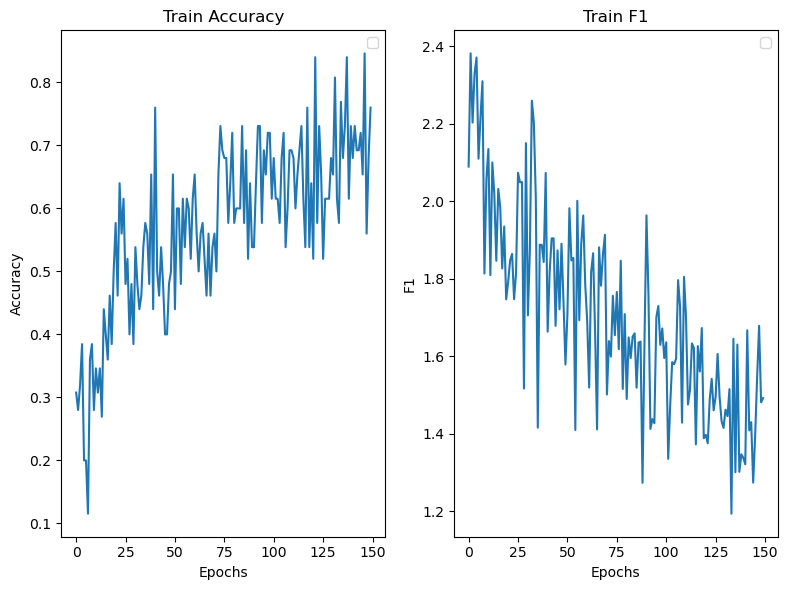

In [15]:
#
# Plot training history
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Train F1')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
image_ids = []
predicted_labels = []

# Get the list of PNG image file names in the test directory
test_files = glob('/kaggle/working/test/*')
for filename in test_files:
    image_id = int(filename.split(".")[0].split("_")[1])
    image_ids.append(image_id)
    
#test_files = load_data(test_files)

for file in test_files:
    # Predict the label
    img = load_img(file, target_size=(299, 299))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    
    predicted_labels.append(predicted_class - 1)

# Create a DataFrame with the image IDs and predicted labels
results_df = pd.DataFrame({'id': image_ids, 'malignant': predicted_labels}) 

1/1 [==============================] - 0s 43ms/step


In [18]:
results_df

,id,malignant
0,292971,-1
1,156941,-1
2,837363,-1
3,49868,-1
4,422756,-1
...,...,...
119,175012,-1
120,407269,-1
121,67507,-1
122,139077,-1


In [19]:
results_df.to_csv("/kaggle/working/submission4.csv", index=False) 